In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import stats
from scipy.integrate import quad
import pandas as pd

# Case 4: Numerical Methods for European Option Pricing

## Part 1: Fourier

In [2]:
r = 0.01       
sigma = 0.15   
T = 10          
t = 0          
n = 100
K = 100
S0 = 100

In [38]:
def charfct(t, Wt, T, xi):
    return np.exp(1j*xi*Wt - (r + 0.5*(xi**2))*(T-t))

In [39]:
def optft(alpha, xi, S0, K, sigma, r, T):
    rsig2t = (r - 0.5 * sigma*sigma) * T

    # wbar = (-rsig2t*T)/sigma
    wbar = (np.log(K/S0) - rsig2t) / sigma
    
    return (-S0 * np.exp(rsig2t + (1j*xi + sigma - alpha) * wbar) / (1j*xi + sigma - alpha) +
          K * np.exp((1j*xi - alpha) * wbar) / (1j*xi - alpha))

In [40]:
def ftint2(xi, alpha):
    return np.real(charfct(t, 0, T, (-xi-1j*alpha)) * optft(alpha, xi, S0, K, sigma, r, T))/(2*np.pi)

In [49]:
def integrate_function(alpha):
    result, _ = quad(lambda xi: ftint2(xi, alpha), -np.inf, np.inf)
    return result

result = integrate_function(0.5)
print(f"Integration result for alpha=0.5: {result}")

Integration result for alpha=0.5: 23.0012346368438


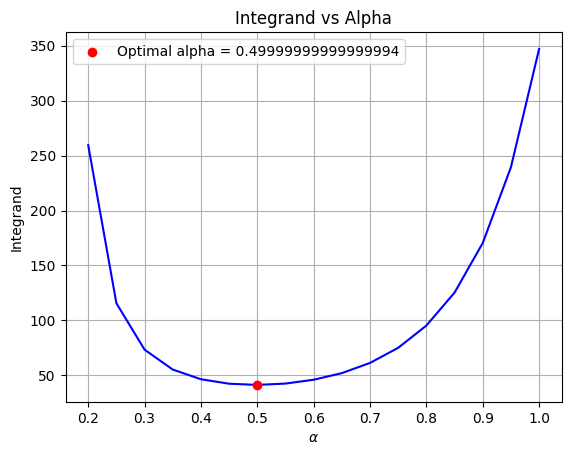

Optimal alpha: 0.49999999999999994


In [42]:
# Calculate integrand values for different alpha values
alpha_values = np.arange(0.2, 1.05, 0.05)
integrand_values = []

for alpha in alpha_values:
    integrand_values.append(ftint2(0, alpha))

# Find the alpha value that minimizes the integrand
optimal_alpha = alpha_values[np.argmin(integrand_values)]

# Plotting the results
plt.plot(alpha_values, integrand_values, color='blue')  # Line without markers
plt.scatter(optimal_alpha, np.min(integrand_values), color='red', zorder=5, label=f'Optimal alpha = {optimal_alpha:}', marker='o')  # Red dot
plt.xlabel(r'$\alpha$')
plt.ylabel('Integrand')
plt.title('Integrand vs Alpha')
plt.grid(True)
plt.legend()
plt.show()

print(f"Optimal alpha: {optimal_alpha}")

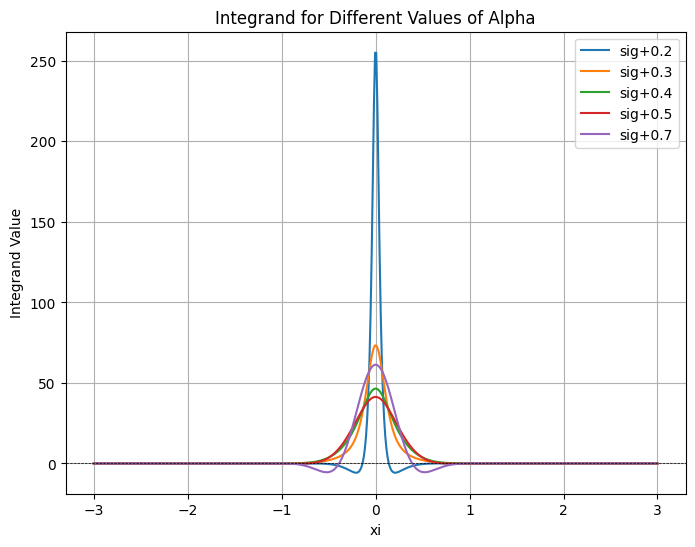

In [44]:
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.7]
results = []

# Calculate integration for each alpha
for alpha in alpha_values:
    results.append(integrate_function(alpha))

# Plotting
plt.figure(figsize=(8, 6))
xi_range = np.linspace(-3, 3, 500)

for alpha in alpha_values:
    y_values = [ftint2(xi, alpha) for xi in xi_range]
    plt.plot(xi_range, y_values, label=f'sig+{alpha}')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('xi')
plt.ylabel('Integrand Value')
plt.title('Integrand for Different Values of Alpha')

plt.legend()
plt.grid()
plt.show()

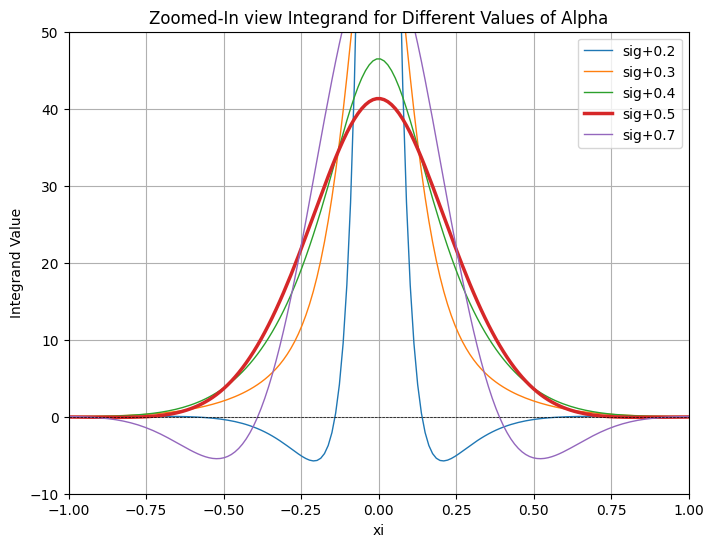

In [45]:
# Plotting with zoom and thicker line for alpha=0.5
plt.figure(figsize=(8, 6))
xi_range = np.linspace(-3, 3, 500)

for alpha in alpha_values:
    y_values = [ftint2(xi, alpha) for xi in xi_range]
    if alpha == 0.5:  # Highlight the line for alpha=0.5
        plt.plot(xi_range, y_values, label=f'sig+{alpha}', linewidth=2.5)
    else:
        plt.plot(xi_range, y_values, label=f'sig+{alpha}', linewidth=1.0)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('xi')
plt.ylabel('Integrand Value')
plt.title('Zoomed-In view Integrand for Different Values of Alpha')

# Adjust the limits for a closer view
plt.xlim(-1, 1)  # Narrowing the x-axis range
plt.ylim(-10, 50)  # Adjust the y-axis range to focus on the most relevant values

plt.legend()
plt.grid()
plt.show()


## Part 2: Finite Difference (Implicit)

In [2]:
def lu_decomposition_tridiagonal(pu, pm, pd, m):

    lowerDiag = np.zeros(2 * m) 
    mainDiag = np.zeros(2 * m + 1)  
    upperDiag = np.zeros(2 * m)  

    mainDiag[0] = pm
    for i in range(1, 2 * m + 1):
        lowerDiag[i - 1] = pd / mainDiag[i - 1]
        mainDiag[i] = pm - lowerDiag[i - 1] * pu
        if i < 2 * m:
            upperDiag[i - 1] = pu

    return lowerDiag, mainDiag, upperDiag

In [3]:
def solve_lu_decomposition(lowerDiag, mainDiag, upperDiag, C, m, lambdaL, lambdaU):

    # Forward substitution (Ly = C)
    y = np.zeros(2 * m + 1)
    y[0] = C[0]
    for i in range(1, 2 * m + 1):
        y[i] = C[i] - lowerDiag[i - 1] * y[i - 1]

    y[0] -= lambdaL
    y[-1] += lambdaU

    # Back substitution (Ux = y)
    x = np.zeros(2 * m + 1)
    x[-1] = y[-1] / mainDiag[-1]
    for i in range(2 * m - 1, -1, -1):
        x[i] = (y[i] - upperDiag[i] * x[i + 1]) / mainDiag[i]

    return x

In [4]:
def initialize_stock_grid(S0, dx, m):
    S = [S0 * np.exp(-m * dx)]  # from the lowest price
    for j in range(1, 2 * m + 1):
        S.append(S[j - 1] * np.exp(dx))
    return S

def initialize_payoff(S, K):
    return np.maximum(S, K)

In [5]:
def implicit_FD(S0, K, T, sigma, r, q, N, m):
 
    dt = T / N  
    dx = np.log(420)/m   # Spatial step 

    # coefficients
    nu = r - q - 0.5 * sigma**2
    pu = -0.5 * dt * ((sigma / dx)**2 + nu / dx)
    pm = 1 + dt * (sigma / dx)**2 + r * dt
    pd = -0.5 * dt * ((sigma / dx)**2 - nu / dx)

    # Initialize the grid for option values and stock prices
    S = initialize_stock_grid(S0, dx, m)
    grid = initialize_payoff(S, K)

    # Boundary conditions
    lambdaU = S[2 * m] - S[2 * m - 1]  # Contract value at high prices
    lambdaL = K * np.exp(-r * dt) - S[0]  # Discounted guarantee at low prices

    # LU decomposition 
    lowerDiag, mainDiag, upperDiag = lu_decomposition_tridiagonal(pu, pm, pd, m)

    # Backward induction
    for i in range(N):
        grid = solve_lu_decomposition(lowerDiag, mainDiag, upperDiag, grid, m, lambdaL, lambdaU)

    return grid[m]

In [10]:
def convergenceAnalysis(S0, K, T, sigma, r, q, numPoints, contractPrice):
    results = []
    for N in [10, 100, 200, 500, 1000, 2000, 5000, 10000]:
        m = numPoints // N  # Keeps total grid points constant
        results.append((N, m, implicit_FD(S0, K, T, sigma, r, q, N, m),
                        abs(implicit_FD(S0, K, T, sigma, r, q, N, m) - contractPrice)))
    return results

In [20]:
# Parameters
S0 = 100
S_Max = 400 # just took any number 
K = 100
T = 10
sigma = 0.15
r = 0.01
q = 0
total_points = 100000  # Total number of grid points
true_value = 113.48497644043974

option_price = implicit_FD(S0, K, T, sigma, r, q, N=1000, m=2000)
print(f"The price of the unit-linked contract is: {option_price:.6f}")

results = convergenceAnalysis(S0, K, T, sigma, r, q, total_points, true_value)

convergence_df = pd.DataFrame(results, columns=["N", "m", "Price", "Error"])
print(convergence_df)

The price of the unit-linked contract is: 113.482538
       N      m       Price     Error
0     10  10000  113.250683  0.234293
1    100   1000  113.461067  0.023909
2    200    500  113.471938  0.013038
3    500    200  113.472550  0.012427
4   1000    100  113.451735  0.033241
5   2000     50  113.359002  0.125974
6   5000     20  112.620472  0.864505
7  10000     10  109.707294  3.777683
